## 00 |

In [1]:
# Basic libraries
import pandas as pd # data manipulatioN
import numpy as np # numerical operations
import matplotlib.pyplot as plt # 2D visualizations
import seaborn as sns # high-resolution visualization
import warnings # warning messages management

# SQL connection
from getpass import getpass # SQL connector
from sqlalchemy import create_engine # route to the engine

# Machine Learning
from sklearn.preprocessing import StandardScaler # normalization
from sklearn.model_selection import train_test_split # splitting data into train/test sets
from sklearn.linear_model import LogisticRegression # logistic model
from sklearn.metrics import accuracy_score # accuarcy
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay # roc curveconfussion matrix & displayer

# Settings
pd.set_option('display.max_columns', None) # display all columns
pd.set_option('display.max_rows', None)# display all rows
warnings.filterwarnings('ignore') # ignore warnings

In [2]:
# Basic functions
def data_info(data): # improved data.info()
    print(f"Data shape is {data.shape}.")
    print()
    print(data.dtypes)
    print()
    print("Data row sample and full columns:")
    return data.sample(5)

## 01 | Data Extraction

In [8]:
# Creating a safe connection
password = getpass("Please, kindly insert your password:")
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'

Please, kindly insert your password: ········


In [9]:
# Getting the data
engine = create_engine(connection_string)
data = pd.read_sql_query('SELECT * FROM logistic_data;', engine)

In [10]:
data_info(data)

Data shape is (958, 8).

film_id               int64
rental_duration       int64
rental_rate         float64
length                int64
rating               object
special_features     object
name                 object
n_rentals             int64
dtype: object

Data row sample and full columns:


,film_id,rental_duration,rental_rate,length,rating,special_features,name,n_rentals
919,288,7,2.99,167,R,Trailers,Travel,25
738,436,4,0.99,122,NC-17,"Trailers,Deleted Scenes",New,19
319,441,5,2.99,125,PG-13,"Commentaries,Deleted Scenes,Behind the Scenes",Documentary,5
670,133,7,4.99,117,NC-17,Trailers,Music,13
706,884,5,4.99,88,R,"Trailers,Deleted Scenes,Behind the Scenes",Music,6


<blockquote style="background-color: #d4edda; color: #155724; border-color: #c3e6cb; padding: 10px; border-radius: 5px;">
    
**First impression:**
    
_____________

The following database is a collection of over **one-year** (from 2005/05/24 to 2006/02/14) 1.958 film's information among 8 different columnns.
    
Our **binary target** will the probability of a movie being rented **again** or **not** in the future. 

--> Target variable: `Movie_demand`. 1 **if** it's bigger than the film rental average **else** 0. Our film rental average is `n_rentals` (a new feature created in [SQL](https://github.com/isi-mube/iron-labs/blob/main/unit_3_sql/lab-predictions-logistic-regression/notebook/sql_database_extraction_process.sql)).

--> Features: `rating`, `special_features` & `name` need to be encoded (they are objects)  
    
**First**, data cleaning:
    
_____________
</blockquote>

## 02 | Data cleaning

In [11]:
# copy before, as best practices
data_copy = data.copy()

### Encoding Categoricals
<blockquote style="background-color: #d1ecf1; color: #0c5460; border-color: #bee5eb; padding: 10px; border-radius: 5px;">|
    
* We imported features such as `rating`, `special_features` and `name` as categoricals, we will use get dummies from pandas to encode them to numericals:
</blockquote>

In [12]:
# Selecting categoricals
cat = data_copy.select_dtypes(include = np.object)
cat.head()

,rating,special_features,name
0,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action
1,R,"Commentaries,Behind the Scenes",Action
2,NC-17,"Trailers,Commentaries,Deleted Scenes",Action
3,G,"Trailers,Commentaries",Action
4,PG-13,Deleted Scenes,Action


In [13]:
# Applying get dummies
cat = pd.get_dummies(cat, columns=['rating', 'special_features', 'name'])
cat.head()

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes",name_Action,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Feature Engineering (target creation)

In [14]:
# Selecting numericals
num = data_copy.select_dtypes(include=np.number)

<blockquote style="background-color: #ffeeba; color: #856404; border-color: #ffeeba; padding: 10px; border-radius: 5px;">
    
Our target is the probability of a movie being rented again or not in the futre. 

--> In a nutshell = `Movie_demand`. 1 **if** it's bigger than the film rental average **else** 0.
    
To create our `target`, we will first look at the distribution of `n_rentals` and calculate the `mean` and `median`. Check the [SQL database-extraction](https://github.com/isi-mube/iron-labs/blob/main/unit_3_sql/lab-predictions-logistic-regression/notebook/sql_database_extraction_process.sql) for more information about this process.</blockquote>

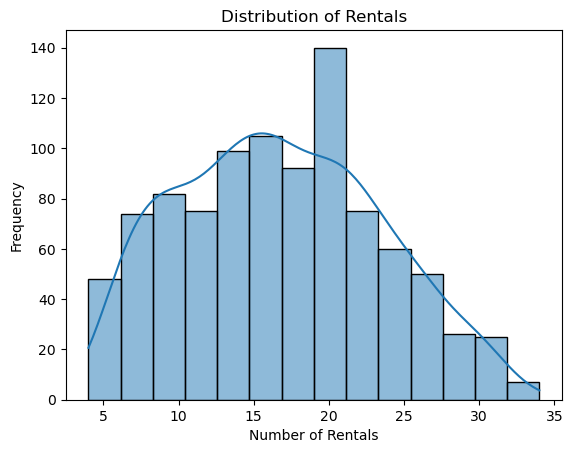

In [15]:
sns.histplot(num['n_rentals'], kde=True)
plt.xlabel('Number of Rentals')
plt.ylabel('Frequency')
plt.title('Distribution of Rentals')
plt.show()

<blockquote style="background-color: #d4edda; color: #155724; border-color: #c3e6cb; padding: 10px; border-radius: 5px;">

The plot shows a bell-curve distribution, meaning a **normal distribution** of the data. We should expect similar mean and median results.
</blockquote>

In [16]:
# Compute the mean and median of n_rentals
n_rentals_mean = num['n_rentals'].mean()
n_rentals_median = num['n_rentals'].median()
print(f"Mean = {n_rentals_mean}")
print(f"Median = {n_rentals_median}")

Mean = 16.747390396659707
Median = 16.0


<blockquote style="background-color: #d4edda; color: #155724; border-color: #c3e6cb; padding: 10px; border-radius: 5px;">

As expected, both average (mean) and the middle value (median) have similar results. We will define our treshold with the **median**. The mean is biased by some outliers.</blockquote>

In [17]:
num['movie_demand'] = [1 if x > n_rentals_median else 0 for x in data['n_rentals']]

In [18]:
# Our target `movie_demnad` should be automatically to the right
data_headers = list(num.columns.values) # to get and check all column names
print("The Column Headers are :", data_headers) 

The Column Headers are : ['film_id', 'rental_duration', 'rental_rate', 'length', 'n_rentals', 'movie_demand']


In [19]:
cat.sample(3)

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes",name_Action,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
758,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
470,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
507,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [20]:
num.sample(3)

,film_id,rental_duration,rental_rate,length,n_rentals,movie_demand
4,67,5,2.99,77,21,1
805,394,7,2.99,146,14,0
241,127,5,4.99,112,30,1


<blockquote style="background-color: #d4edda; color: #155724; border-color: #c3e6cb; padding: 10px; border-radius: 5px;">

**Now**, we have a dataset containing categoricals encoded (cat) & another for all previous numericals + our target `movie_demand`.

**Important**: We will do `concat` after **EDA** to merge cat & num in one single dataframe.
</blockquote>

## 03 | EDA

### Overview

In [21]:
num.describe()

,film_id,rental_duration,rental_rate,length,n_rentals,movie_demand
count,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000
mean,502.598121,4.969729,2.977474,115.490605,16.747390,0.495825
std,287.541738,1.407593,1.643152,40.471844,6.676185,0.500244
min,1.000000,3.000000,0.990000,46.000000,4.000000,0.000000
25%,256.250000,4.000000,0.990000,80.250000,11.000000,0.000000
50%,504.500000,5.000000,2.990000,114.000000,16.000000,0.000000
75%,751.750000,6.000000,4.990000,150.000000,22.000000,1.000000
max,1000.000000,7.000000,4.990000,185.000000,34.000000,1.000000


### Checking for outliers

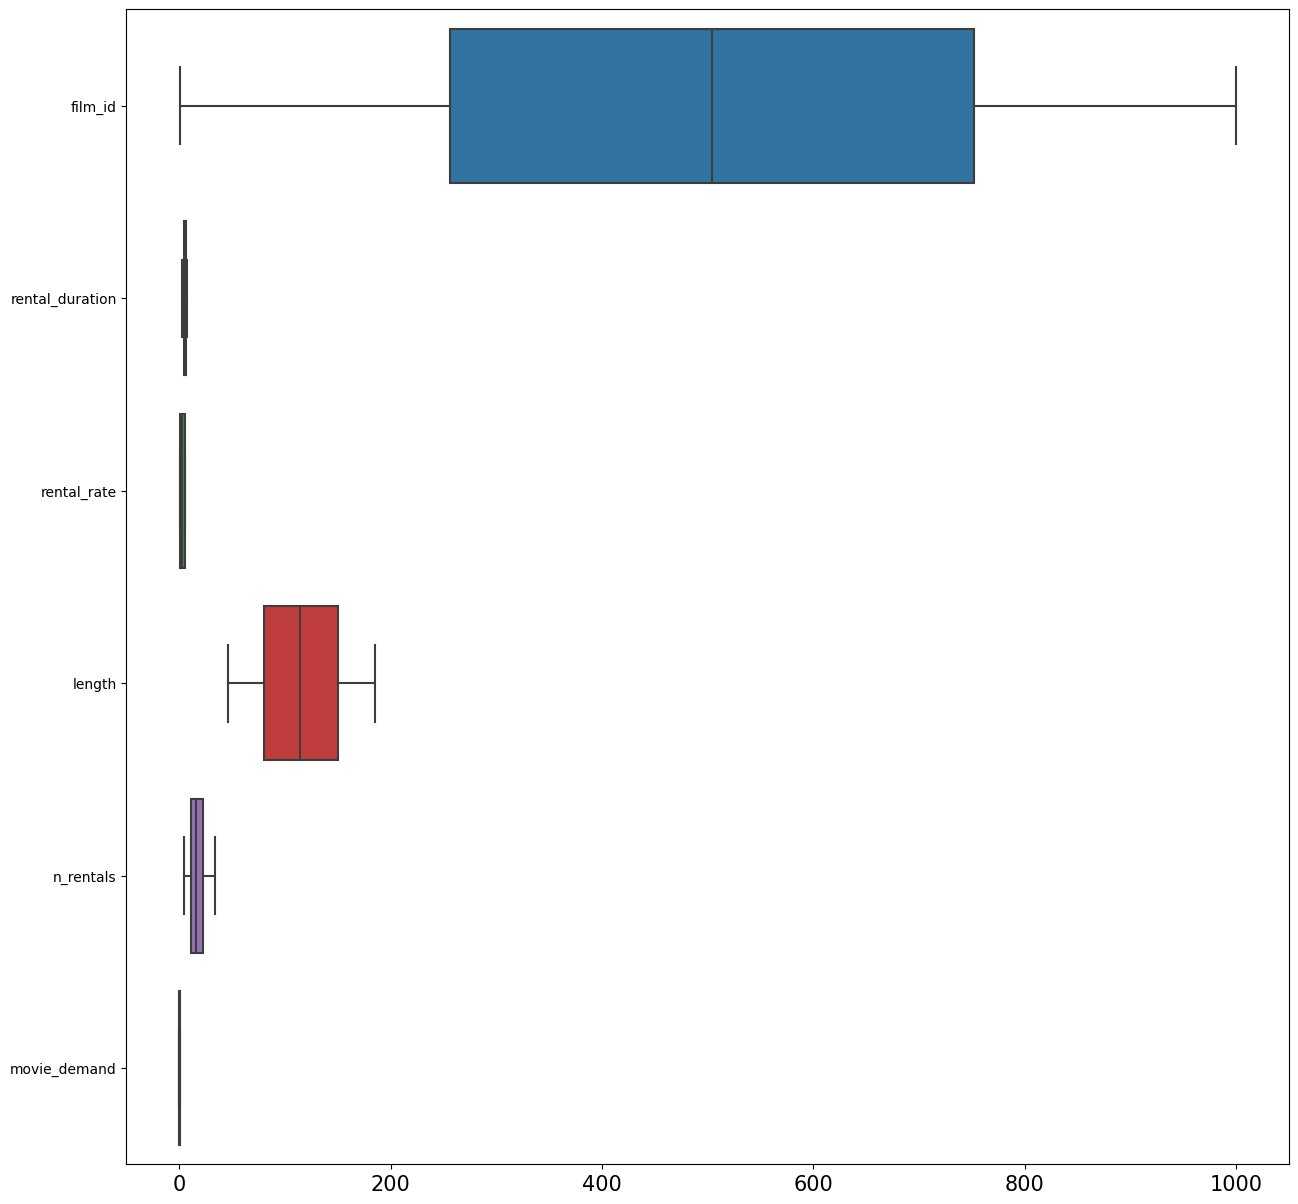

In [22]:
# For previously numerical columns
fig, ax = plt.subplots(figsize=(15, 15))
sns.boxplot(data=num, orient="h", ax=ax, showfliers=True, whis=1.5)
ax.tick_params(axis='x', labelsize=15) # Adjust the font size of the x-axis ticks
# Show the plot
plt.show()

<blockquote style="background-color: #d4edda; color: #155724; border-color: #c3e6cb; padding: 10px; border-radius: 5px;">
There are not visible outliers. 

**Meaning**, the data could be normally distributed.
</blockquote>

### Checking normal distributions

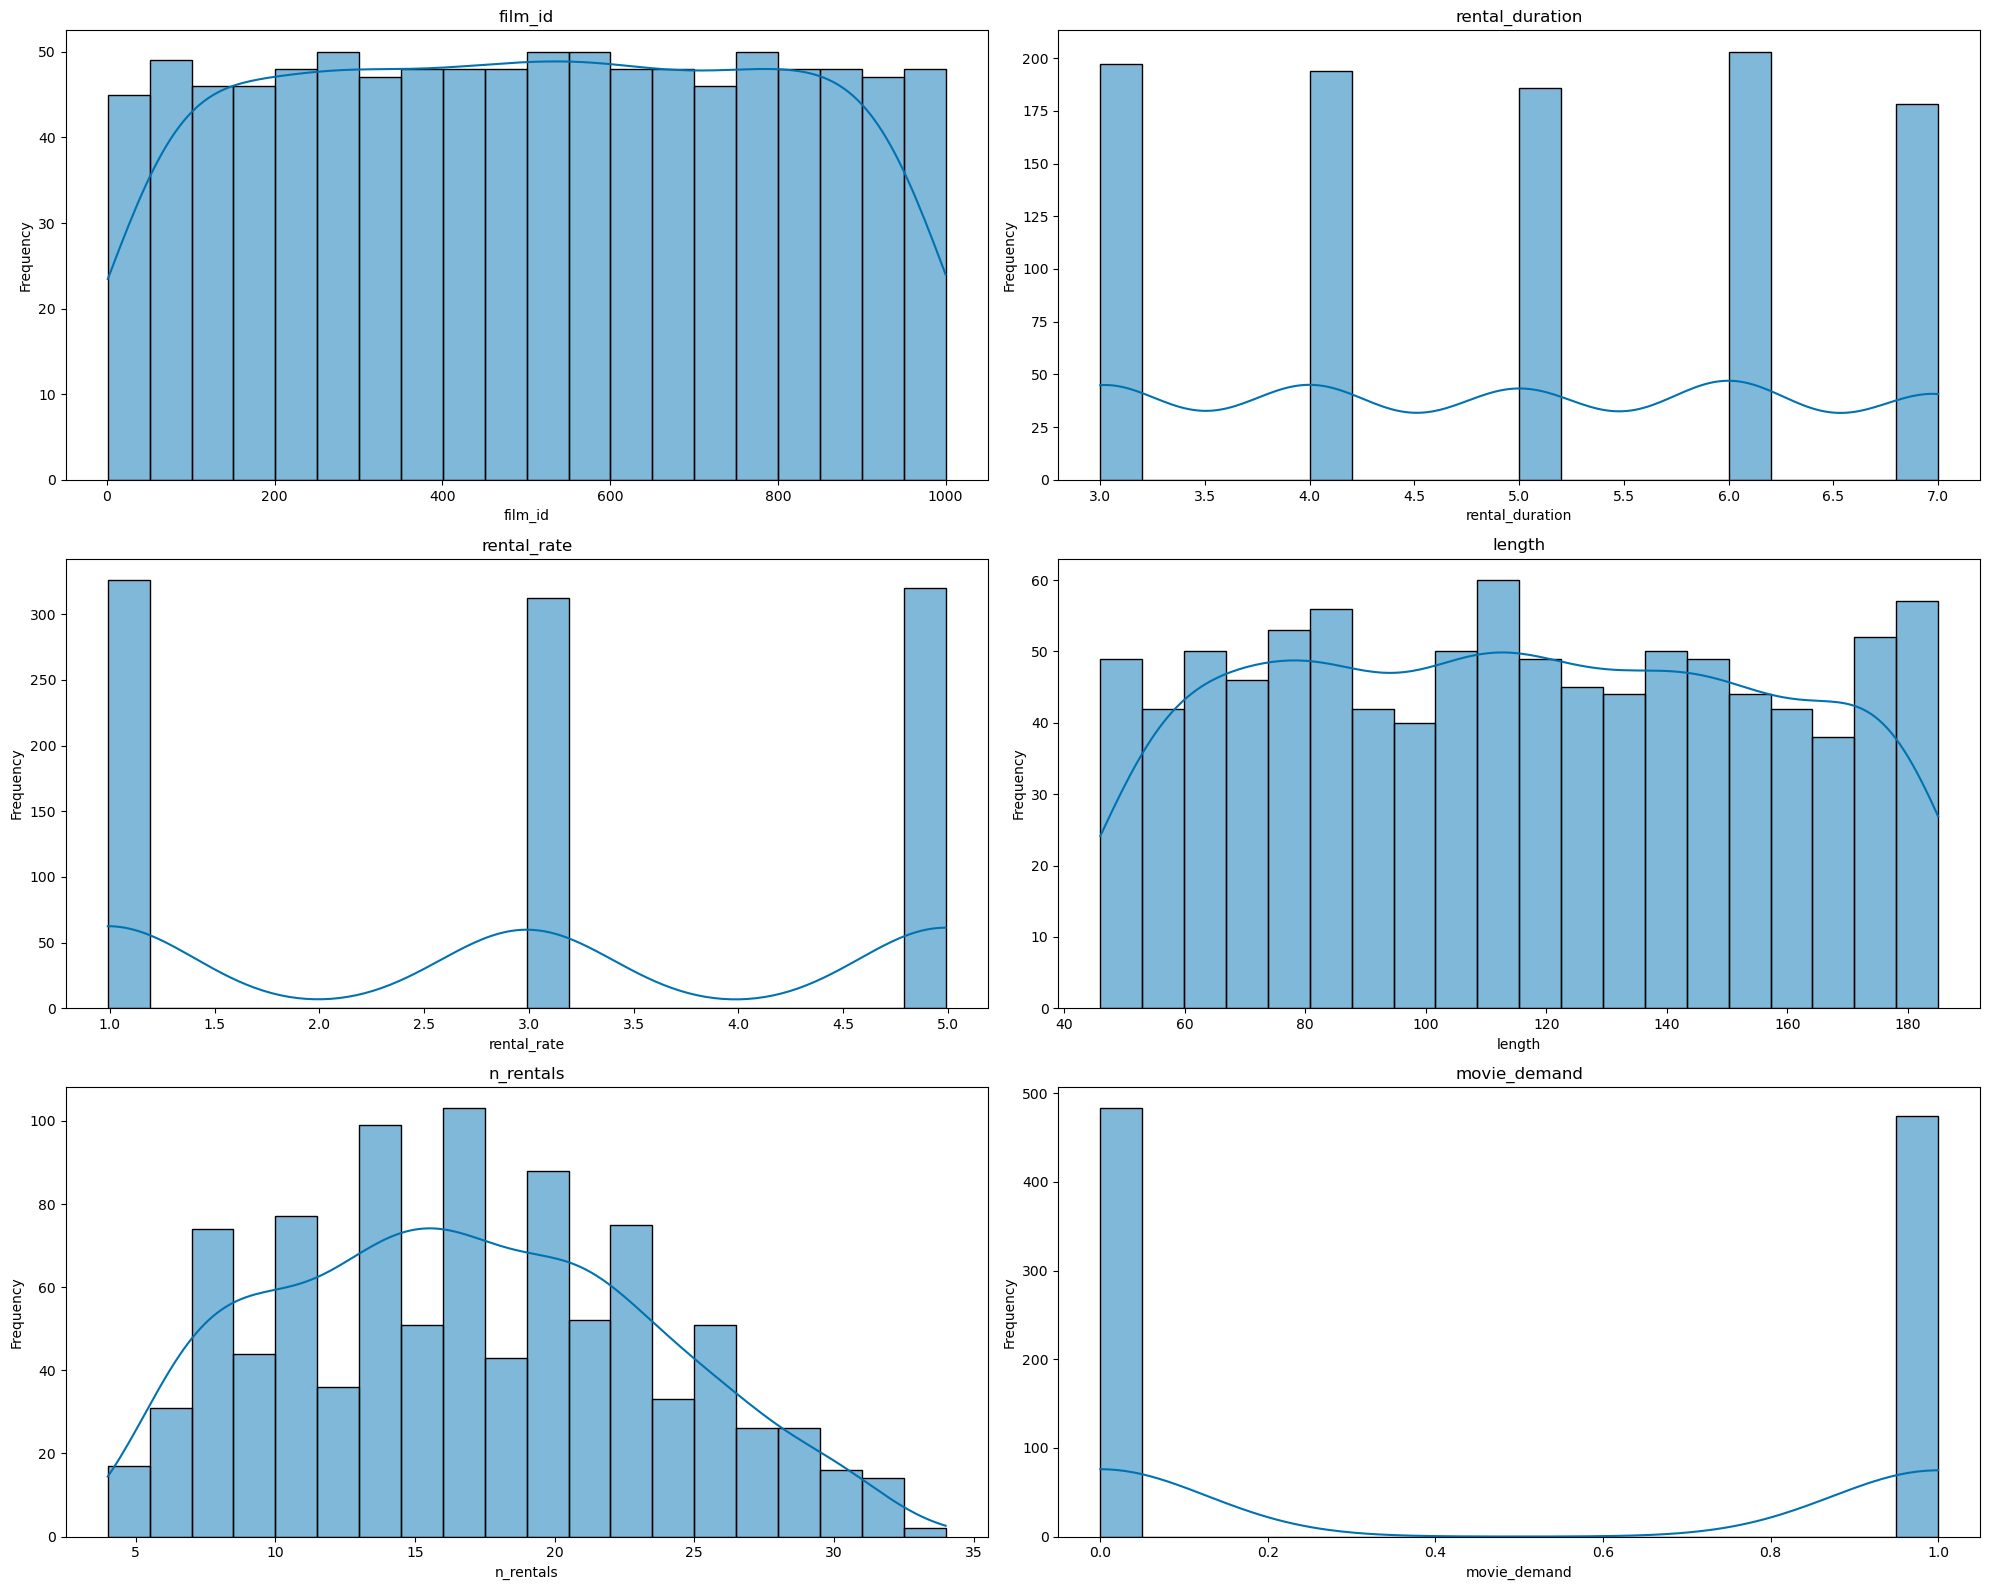

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 16))  # nrows to 9, ncols to 5 to plot our 42 features
color = '#0072B2'  # blue

for i, ax in enumerate(axes.flat):
    if i >= len(num.columns):
        break
    sns.histplot(data=num, x=num.columns[i], color=color, bins=20, kde=True, ax=ax)
    ax.set_title(num.columns[i])
    ax.set_xlabel(num.columns[i])
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

<blockquote style="background-color: #d4edda; color: #155724; border-color: #c3e6cb; padding: 10px; border-radius: 5px;">

As expected, data was normaly distributed. Except for `n_rentals`, `rental_duration` & `movie_demand`, which are divided by major blocks.</blockquote>

### Dealing with multicollinearity

In [24]:
# Creating the matrix
X_corr = round(num.corr(), 4)

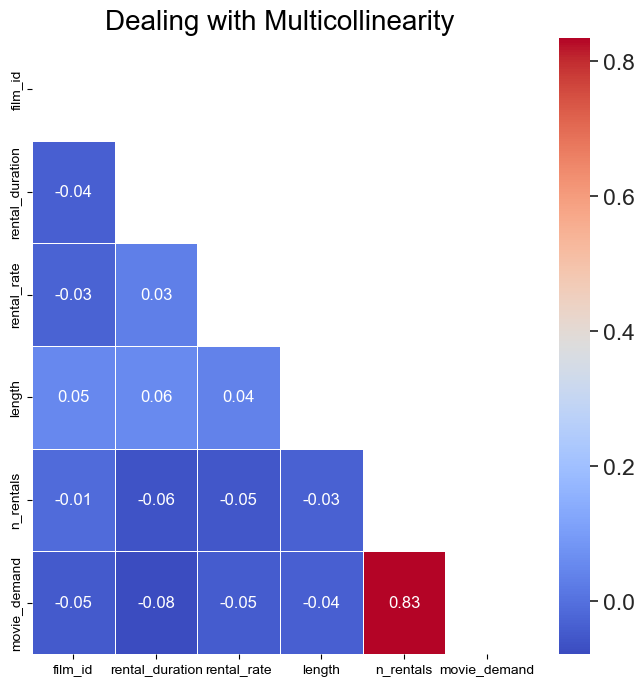

In [25]:
# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(X_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.set(font_scale=1.5) # increase font size
ax = sns.heatmap(X_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Dealing with Multicollinearity", fontsize=20) # add title
plt.show()

<blockquote style="background-color: #d4edda; color: #155724; border-color: #c3e6cb; padding: 10px; border-radius: 5px;">

There is one feature , `n_rentals`, that shows high correlation with our target `movie_demands` as it could be expected. Also, it does not show multicollinearity with the other features. 
    
In this process, there is nothing to drop, so now it's time to normalize numericals to finally merge it with the rest of our data:
</blockquote>num2 = num.drop(columns=['movie_demand'])


## 04 | Data Processing

### Normalizing the data

<blockquote style="background-color: #ffeeba; color: #856404; border-color: #ffeeba; padding: 10px; border-radius: 5px;">

In a previous attempt we did not normalize our numericals. This time we will use `StandScaler`:

</blockquote>

In [26]:
num.head(3)

,film_id,rental_duration,rental_rate,length,n_rentals,movie_demand
0,19,6,0.99,113,21,1
1,21,3,4.99,129,22,1
2,29,5,2.99,168,10,0


In [27]:
# We don't want to normalize the target
num2 = num.drop(columns=['movie_demand'])

# Selecting the scaler
transformer = StandardScaler().fit(num2)

n = transformer.transform(num2)
n = pd.DataFrame(n) # making it a panda dataframe
n['movie_demand'] = num['movie_demand'] # adding our target
n.columns = num.columns # keeping old columns
n.sample(3)

,film_id,rental_duration,rental_rate,length,n_rentals,movie_demand
194,-0.882413,1.443124,-1.210182,1.495879,0.637315,1
103,0.516375,-1.400090,-1.210182,-0.778493,0.787179,1
824,1.254044,0.021517,-1.210182,0.630629,1.236772,1


### Merging Categoricals and Numericals

In [28]:
# Merging the two dataframes
X_N = pd.concat([cat, n], axis=1)
X_N.sample(3)

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes",name_Action,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel,film_id,rental_duration,rental_rate,length,n_rentals,movie_demand
680,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.485742,-1.400090,-1.210182,-1.520136,0.487450,1
419,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-1.599205,0.732321,0.007627,1.347551,1.086908,1
179,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.480217,0.021517,0.007627,-0.778493,-0.711465,0


### X-Y Split

In [29]:
# We need to be careful about when and how we do the split.
Y = X_N['movie_demand']
X = X_N.drop(['movie_demand'], axis=1)

## 05 | Modeling

### Train-Test Split

In [30]:
# We define train and test for X and Y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42) 

# test_size = We give 30% for testing and 70% for testing
# random_state = it'll improve the model to divide always the model in the same way

In [31]:
len(X) # Len before the test

958

In [32]:
len(X_test) # Len after testing 30% of X data

288

In [33]:
len(X_train) # Len after training 70% of X data

670

### Logistic Regression

In [34]:
# We traing the training dataset using Logistic Regression
logistic = LogisticRegression(random_state=0).fit(X_train, y_train)

<blockquote style="background-color: #d1ecf1; color: #0c5460; border-color: #bee5eb; padding: 10px; border-radius: 5px;">
To visualize the predictions, we will count all predicted values.
    
* If the model predicts **1** means the movie has a high demand, and it'll be probably be rented again.
* Else, **0** means the movie has a low demand.</blockquote>


In [35]:
# Predictions
predictions = logistic.predict(X_test)
# Converting the numpy array to panda series
pd.Series(predictions).value_counts()

0    144
1    144
dtype: int64

In [36]:
# We compare it to the true values from historical data
y_test.value_counts()

1    146
0    142
Name: movie_demand, dtype: int64

<blockquote style="background-color: #d4edda; color: #155724; border-color: #c3e6cb; padding: 10px; border-radius: 5px;">
    
Both **predictions** and **true** values look very similar. 
We will make an **accuarcy** & confussion matrix to evaluate the model.
</blockquote>

### Predictions

In [37]:
# Predictions
predictions = logistic.predict(X_test)

### Accuaracy evaluation

In [38]:
accuracy = accuracy_score(y_test, predictions)

#Printing the results
print(f"Accuracy = {accuracy:.2f}")

Accuracy = 0.99


### Confussion matrix evaluation

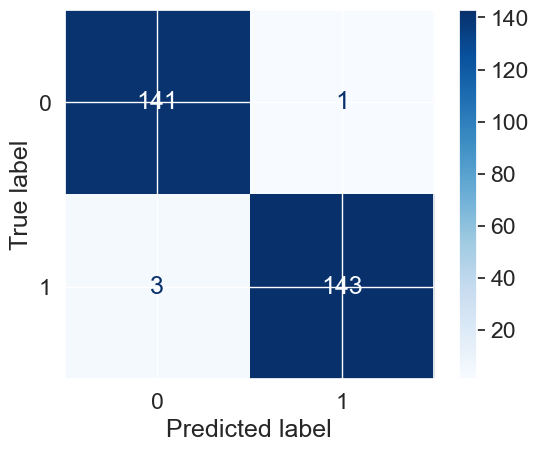

In [39]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

<blockquote style="background-color: #d4edda; color: #155724; border-color: #c3e6cb; padding: 10px; border-radius: 5px;">

Our model has:
* **141** True Negatives Vs **1** False Positive
* & **143** True Positives Vs **3** False Negatives
    
And an **accuracy** of 99%!
</blockquote>

## 06 | Reporting

### Presenting the results

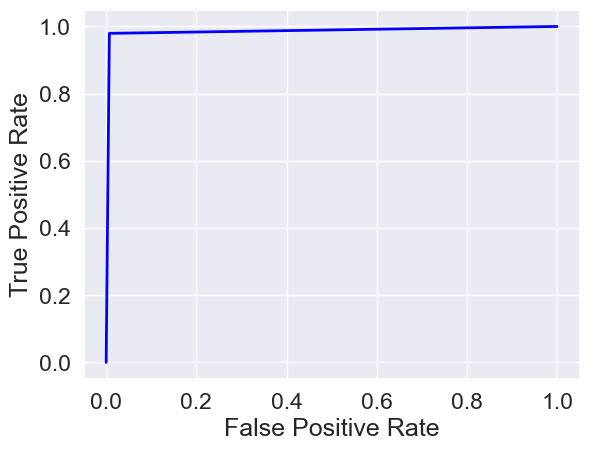

In [35]:
# From Nati's ! Ty!!!
# Calculate fpr, tpr, and threshold values for ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### So... Will the movie be rented in the future?

In [36]:
train_predictions = logistic.predict(X_train)
test_predictions = logistic.predict(X_test)

In [37]:
# Add the predicted demand column to the train and test sets
X_train['predicted_demand'] = train_predictions
X_test['predicted_demand'] = test_predictions

In [38]:
# Combine the train and test sets
X_full = pd.concat([X_train, X_test])
X_full['movie_demand'] = pd.concat([y_train, y_test])

In [39]:
# Adding the new column `predicted_demand` to the previous num dataset
num['predicted_demand'] = X_full['predicted_demand']

### Top 5 movie rentals

In [40]:
# Display the entire dataset with the new predicted_demand column
num[['film_id', 'n_rentals', 'movie_demand', 'predicted_demand']].sort_values(by='n_rentals', ascending=False).head(5)

,film_id,n_rentals,movie_demand,predicted_demand
909,103,34,1,1
536,738,33,1,1
757,730,32,1,1
572,382,32,1,1
93,489,32,1,1


<blockquote style="background-color: #d4edda; color: #155724; border-color: #c3e6cb; padding: 10px; border-radius: 5px;">

So, for example, **film_id** `103` is a movie with high demand, and we should keep more copies to our inventory. To get the name of the film: </blockquote>

In [41]:
film_title = pd.read_sql_query('SELECT * FROM film WHERE film_id = 103;', engine)
film_title.head()

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,103,BUCKET BROTHERHOOD,A Amazing Display of a Girl And a Womanizer wh...,2006,1,None,7,4.99,133,27.99,PG,"Commentaries,Deleted Scenes",2006-02-15 05:03:42


### Less rented film

In [42]:
num[['film_id', 'n_rentals', 'movie_demand', 'predicted_demand']].sort_values(by='n_rentals', ascending=True).head(1)

,film_id,n_rentals,movie_demand,predicted_demand
315,400,4,0,0


<blockquote style="background-color: #d4edda; color: #155724; border-color: #c3e6cb; padding: 10px; border-radius: 5px;">

& film_id 400 had been rented 4 times during 2005/05/24 to 2006/02/14 and it's not expected to be in demand. Again, to get the name of the film </blockquote>

In [43]:
film_title = pd.read_sql_query('SELECT * FROM film WHERE film_id = 400;', engine)
film_title.head()

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,400,HARDLY ROBBERS,A Emotional Character Study of a Hunter And a ...,2006,1,None,7,2.99,72,15.99,R,"Trailers,Behind the Scenes",2006-02-15 05:03:42
